# Salinity anomalies

This notebook contains the processing code to plot salinity anomalies over the 2015-2019 record.

***

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

### Processing

Load the meshmask file

In [3]:
# Load mask
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

Load the Fraser River Hope gauge from Rich's arcive

In [4]:
# Quick load Fraser hydrograph
Fraser = {}
data = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][1].flatten()
Fraser['date'] = np.array([
    datetime.fromordinal(int(mtime)) +
    timedelta(days=float(mtime)%1) - timedelta(days=366)
    for mtime in data['fraser'][0][0][0]
])

Load salinity from the daily hindcast. There's a nifty function in `nc_tools` called `get_hindcast_prefix()` that returns the local hindcast path for a given date. (This whole routine should be optimized using Dask and mfdataset, but I wrote this in a hurry. Takes about 5 minutes on Salish as written.)

In [5]:
# Initialize storage dict and define domain slice and seasons
salinity = {}
slc = (slice(None), 0, slice(334, 790), slice(114, 390))
seasons = {'Apr-Jun': [4, 7], 'Jul-Sep': [7, 10]}

# Loop through years
for year in tqdm(range(2015, 2020)):
    salinity[year] = {}
    
    # Loop through seasons
    for season in seasons:
        salinity[year][season] = []
        bounds = [datetime(year, month, 1) for month in seasons[season]]
        
        # Open the daily results file for each day in the season and append salinity to list
        days = int(np.diff(bounds)[0].total_seconds() / 86400)
        for day in range(days):
            date = bounds[0] + timedelta(days=day)
            filename = nc_tools.get_hindcast_prefix(date, res='d') + '_grid_T.nc'
            with xr.open_dataset(filename) as ds:
                salinity[year][season].append(ds.vosaline[slc].values)
        
        # Concatenate the salinity list elements and average over time
        salinity[year][season] = np.concatenate(salinity[year][season], axis=0).mean(axis=0)

# Calculate the mean across all years for each season
salinity['mean'] = {}
for season in seasons:
    salinity['mean'][season] = [salinity[year][season][None, ...] for year in range(2015, 2020)]
    salinity['mean'][season] = np.concatenate(salinity['mean'][season], axis=0).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

***

### Visualization

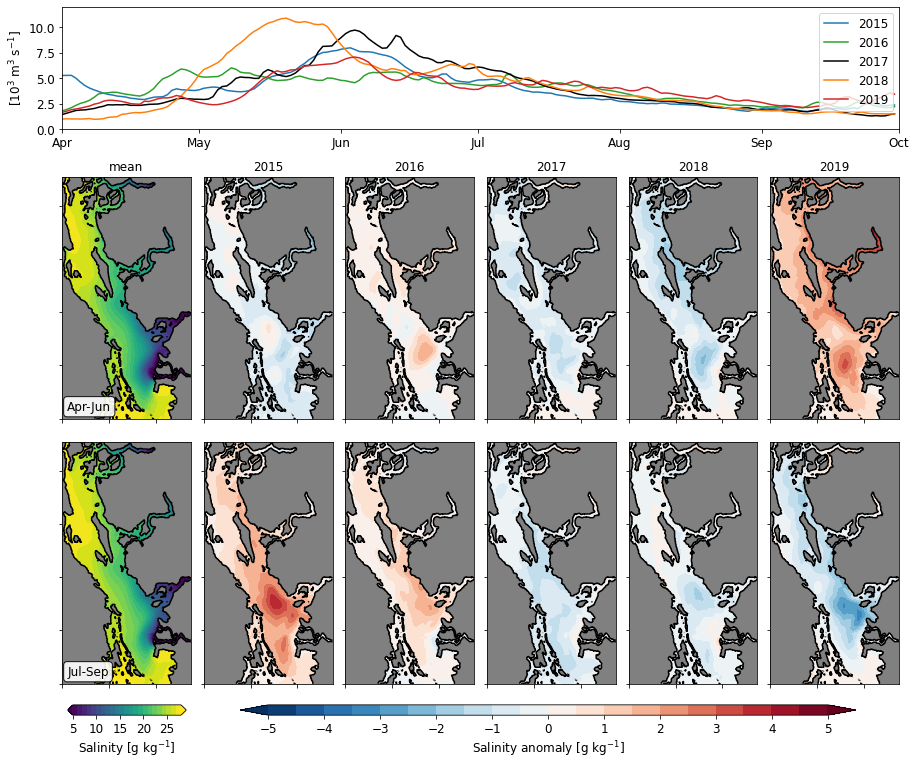

In [7]:
# Build figure layout
fig = plt.figure(figsize=(15, 12))
gs = plt.GridSpec(3, 6, wspace=0.1, hspace=0.1, height_ratios=[1, 2, 2])
ax = fig.add_subplot(gs[0, :])
pos = ax.get_position()
pos.y0, pos.y1 = pos.y0 + 0.03, pos.y1 + 0.03
ax.set_position(pos.bounds)

# Plotting properties
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]

# Plot Fraser hydrograph
for year, color in zip(range(2015, 2020), palette):
    index = np.logical_and(Fraser['date'] >= datetime(year, 4, 1), Fraser['date'] < datetime(year, 10, 1))
    x = [datetime(2020, t.month, t.day) for t in Fraser['date'][index]]
    ax.plot(x, 1e-3*Fraser['flow'][index], color=color, label=year)
ax.set_xlim([datetime(2020, 4, 1), datetime(2020, 10, 1)])
ax.set_ylim([0, 12])
ax.set_ylabel('[10$^3$ m$^3$ s$^{-1}$]')
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
ax.legend()

# Plot mean and anomalies
for row, season in zip(range(1, 3), seasons):
    for col, key in zip(range(6), ['mean'] + list(range(2015, 2020))):
        ax = fig.add_subplot(gs[row, col])
        ax.contourf(mask.tmask[(0,)+slc[1:]], levels=[-0.01, 0.01], colors='gray', zorder=2)
        ax.contour(mask.tmask[(0,)+slc[1:]], levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticklabels('')
        ax.yaxis.set_ticklabels('')
        ax.set_aspect(5/4.4)
        if key == 'mean':
            c1 = ax.contourf(salinity[key][season], levels=np.arange(5, 29), extend='both')
            ax.text(0.04, 0.035, season, transform=ax.transAxes, bbox=bbox)
        else: c2 = ax.contourf(salinity[key][season] - salinity['mean'][season], levels=np.arange(-5, 5.1, 0.5), cmap='RdBu_r', extend='both')
        if season == 'Apr-Jun': ax.set_title(key)

# Add colorbars
for c, xpos, ticks, label in zip([c1, c2], [(0.13, 0.11), (0.29, 0.57)], [(5, 26, 5), (-5, 6, 1)], ['Salinity', 'Salinity anomaly']):
    cax = fig.add_axes([xpos[0], 0.09, xpos[1], 0.012])
    fig.colorbar(c, cax=cax, orientation='horizontal', label=f'{label} [g kg$^{{-1}}$]', ticks=np.arange(*ticks))

#fig.savefig('/home/bmoorema/Desktop/upwelling_processes_figs/salinity_anomalies.pdf', bbox_inches='tight')